# ![title](http://blog.varunajayasiri.com/ml/lstm.svg)

# LSTM in  NumPy
I wanted to understand the inner workings of an LSTM Recurrent Neural Network which led me to scour the internet for links.  The best link by far is [Christopher Olah's blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). I've been using LSTM's for awhile with Keras and TensorFlow, however these libraries don't help you understand the nuts and bolts of a Long Short Term RNN.

I attempted to implement the network in NumPy, but because of a lack of time I had to give up.  Instead, I found Nick Jimenez's python classes to be highly useful:
NumPy taken from [Nicolas D. Jimenez's GitHub](https://github.com/nicodjimenez).  

I used 10 rows from my wind direction dataset and converted the wind direction to a sine wave.  I made a few adjustments to the network such as Adam optimization.  Below I walkthrough the network in English, mostly as an exercise for myself to understand the memory in backpropagation.

#### Adam Optimization
I implemented Adam optimization to the network rather than using SGD.  I used a GitHub page to help me write this, but I can't seem to find the link now.  Below I graphed a learning comparison of Adam vs SGD, both with a learning rate of 0.1. 

An interesting note on Adam optimization was that the network was only able to learn well with Adam optimization after initializing weights to <br>
(np.random.rand(*args) * (.2) -.1)*.1<br>
Very low weight initialization was required for the network to learn the data with Adam; Adam optimization only worked well after the "*.1" was added.  Adam optimization did however learn more effectively than SGD after this modification.  With the original original SGD weight initialization, the final loss on the network with this data was 0.18.  After adjusting the weight initialization, SGD loss was .26 and Adam loss was .0013.
Training SGD for more iterations would make up for its learning deficiencies compared to Adam.   

Turbine name: R80736
Training...
iter  0: y_pred = [-0.00022,  0.00051,  0.00034,  0.00070,  0.00028,  0.00122], loss: 3.332e+00
iter 50: y_pred = [ 0.47206, -0.16051,  0.51563,  0.52871, -0.54239, -0.49950], loss: 8.613e-01
Actual vs Predicted:
[ 0.64447554 -0.92569097  0.6678121   0.9735639  -0.68801814 -0.43752836]
[0.5869153998588292, -0.4670886537363172, 0.5520156916916225, 0.7768378584348697, -0.7074944282921246, -0.4815653387488001]


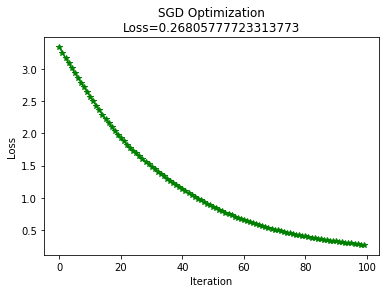

Training...
iter  0: y_pred = [-0.00022,  0.00051,  0.00034,  0.00070,  0.00028,  0.00122], loss: 3.332e+00
iter 50: y_pred = [ 0.62422, -0.83417,  0.63624,  0.81116, -0.69211, -0.53279], loss: 4.525e-02
Actual vs Predicted:
[ 0.64447554 -0.92569097  0.6678121   0.9735639  -0.68801814 -0.43752836]
[0.6452756994939641, -0.9033736746297787, 0.6690755544839511, 0.9535165763784924, -0.6837271453973008, -0.41737458799120275]


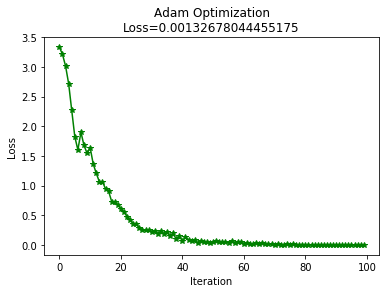

In [2]:
import numpy as np
import sys
import pandas as pd
import datetime
import sys
import random
import time
import math
from matplotlib import pyplot as plt

class Optimizer:
    #USE SAME DEFAULTS AS KERAS ADAM OPTIMIZER
    def __init__(self, lr=.1, beta_1=0.9, beta_2=0.999,
                 epsilon=0, decay=0., **kwargs):
        
        allowed_kwargs = {'clipnorm', 'clipvalue'}
        for k in kwargs:
            if k not in allowed_kwargs:
                raise TypeError('Unexpected keyword argument '
                                'passed to optimizer: ' + str(k))
        self.__dict__.update(kwargs)
        self.iterations = 1
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.decay = decay
        self.epsilon = epsilon
        self.initial_decay = decay

    def get_ADAM(self, params, grads):

        original_shapes = [x.shape for x in params]
        params = [x.flatten() for x in params]
        grads = [x.flatten() for x in grads]
        
        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * self.iterations))

        t = self.iterations + 1
        lr_t = lr * (np.sqrt(1. - np.power(self.beta_2, t)) /
                     (1. - np.power(self.beta_1, t)))

        if not hasattr(self, 'ms'):
            self.ms = [np.zeros(p.shape) for p in params]
            self.vs = [np.zeros(p.shape) for p in params]
    
        ret = [None] * len(params)
        for i, p, g, m, v in zip(range(len(params)), params, grads, self.ms, self.vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * np.square(g)
            p_t = p - lr_t * m_t / (np.sqrt(v_t) + self.epsilon)
            self.ms[i] = m_t
            self.vs[i] = v_t
            ret[i] = p_t
        self.iterations += 1
  
        for i in range(len(ret)):
            ret[i] = ret[i].reshape(original_shapes[i])

        return np.array(ret)


    def get_SGD(self, w,p):
        for x,y in zip(w,p):
                    x+=self.lr*y
        return w[0],w[1],w[2],w[3],w[4],w[5],w[6],w[7],w[8],w[9]

def sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def sigmoid_derivative(values): 
    return values*(1-values)

def tanh_derivative(values): 
    return 1. - values ** 2

# createst uniform random array w/ values in [a,b) and shape args
def rand_arr(a, b, *args): 
    np.random.seed(0)
    return (np.random.rand(*args) * (b - a) + a)*.1

class LstmParam:
    def __init__(self, mem_cell_ct, x_dim,optimization):
        self.mem_cell_ct = mem_cell_ct
        self.x_dim = x_dim
        concat_len = x_dim + mem_cell_ct
        
        self.opt=Optimizer()
        self.optimization=optimization

        # weight matrices
        self.wg = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        self.wi = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len) 
        self.wf = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        self.wo = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)

        # bias terms
        self.bg = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bi = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bf = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bo = rand_arr(-0.1, 0.1, mem_cell_ct)


        
        # diffs (derivative of loss function w.r.t. all parameters)
        self.wg_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wi_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wf_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wo_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.bg_diff = np.zeros(mem_cell_ct) 
        self.bi_diff = np.zeros(mem_cell_ct) 
        self.bf_diff = np.zeros(mem_cell_ct) 
        self.bo_diff = np.zeros(mem_cell_ct) 

    def apply_diff(self, lr = .1):
        if(self.optimization=='adam'):
            self.wg=self.opt.get_ADAM(self.wg,self.wg_diff)
            self.wi=self.opt.get_ADAM(np.array(self.wi),np.array(self.wi_diff))
            self.wf=self.opt.get_ADAM(np.array(self.wf),np.array(self.wf_diff))
            self.wo=self.opt.get_ADAM(np.array(self.wo),np.array(self.wo_diff))

        else:
            #This is the stochastic gradient descent code
            self.wg -= lr * self.wg_diff
            self.wi -= lr * self.wi_diff
            self.wf -= lr * self.wf_diff
            self.wo -= lr * self.wo_diff


        
        self.bg -= lr * self.bg_diff
        self.bi -= lr * self.bi_diff
        self.bf -= lr * self.bf_diff
        self.bo -= lr * self.bo_diff
        
        # reset diffs to zero
        self.wg_diff = np.zeros_like(self.wg)
        self.wi_diff = np.zeros_like(self.wi) 
        self.wf_diff = np.zeros_like(self.wf) 
        self.wo_diff = np.zeros_like(self.wo) 
        self.bg_diff = np.zeros_like(self.bg)
        self.bi_diff = np.zeros_like(self.bi) 
        self.bf_diff = np.zeros_like(self.bf) 
        self.bo_diff = np.zeros_like(self.bo) 

class LstmState:
    def __init__(self, mem_cell_ct, x_dim):
        self.g = np.zeros(mem_cell_ct)
        self.i = np.zeros(mem_cell_ct)
        self.f = np.zeros(mem_cell_ct)
        self.o = np.zeros(mem_cell_ct)
        self.s = np.zeros(mem_cell_ct)
        self.h = np.zeros(mem_cell_ct)
        self.bottom_diff_h = np.zeros_like(self.h)
        self.bottom_diff_s = np.zeros_like(self.s)
    
class LstmNode:
    def __init__(self, lstm_param, lstm_state):
        # store reference to parameters and to activations
        self.state = lstm_state
        self.param = lstm_param

        # non-recurrent input concatenated with recurrent input
        self.xc = None

    def bottom_data_is(self, x, s_prev = None, h_prev = None):
        # if this is the first lstm node in the network
        if s_prev is None: s_prev = np.zeros_like(self.state.s)
        if h_prev is None: h_prev = np.zeros_like(self.state.h)
        # save data for use in backprop
        self.s_prev = s_prev
        self.h_prev = h_prev

        # concatenate x(t) and h(t-1)
        xc = np.hstack((x,  h_prev))
        self.state.g = np.tanh(np.dot(self.param.wg, xc) + self.param.bg)
        self.state.i = sigmoid(np.dot(self.param.wi, xc) + self.param.bi)
        self.state.f = sigmoid(np.dot(self.param.wf, xc) + self.param.bf)
        self.state.o = sigmoid(np.dot(self.param.wo, xc) + self.param.bo)
        self.state.s = self.state.g * self.state.i + s_prev * self.state.f
        self.state.h = self.state.s * self.state.o

        self.xc = xc

    
    def top_diff_is(self, top_diff_h, top_diff_s):
        # notice that top_diff_s is carried along the constant error carousel
        ds = self.state.o * top_diff_h + top_diff_s
        do = self.state.s * top_diff_h
        di = self.state.g * ds
        dg = self.state.i * ds
        df = self.s_prev * ds

        # diffs w.r.t. vector inside sigma / tanh function
        di_input = sigmoid_derivative(self.state.i) * di 
        df_input = sigmoid_derivative(self.state.f) * df 
        do_input = sigmoid_derivative(self.state.o) * do 
        dg_input = tanh_derivative(self.state.g) * dg

        # diffs w.r.t. inputs
        self.param.wi_diff += np.outer(di_input, self.xc)
        self.param.wf_diff += np.outer(df_input, self.xc)
        self.param.wo_diff += np.outer(do_input, self.xc)
        self.param.wg_diff += np.outer(dg_input, self.xc)
        self.param.bi_diff += di_input
        self.param.bf_diff += df_input       
        self.param.bo_diff += do_input
        self.param.bg_diff += dg_input

        #for dparam in [self.param.wi_diff, self.param.wf_diff , self.param.wo_diff, self.param.wg_diff, self.param.bi_diff, self.param.bf_diff, self.param.bo_diff, self.param.bg_diff]:
        #    np.clip(dparam, -1, 1, out=dparam)

        # compute bottom diff
        dxc = np.zeros_like(self.xc)
        dxc += np.dot(self.param.wi.T, di_input)
        dxc += np.dot(self.param.wf.T, df_input)
        dxc += np.dot(self.param.wo.T, do_input)
        dxc += np.dot(self.param.wg.T, dg_input)

        # save bottom diffs
        self.state.bottom_diff_s = ds * self.state.f
        self.state.bottom_diff_h = dxc[self.param.x_dim:]

class LstmNetwork():
    def __init__(self, lstm_param, loss):
        self.lstm_param = lstm_param
        self.lstm_node_list = []
        # input sequence
        self.x_list = []
        self.loss=loss

    def y_list_is(self, y_list, loss_layer):
        """
        Updates diffs by setting target sequence 
        with corresponding loss layer. 
        Will *NOT* update parameters.  To update parameters,
        call self.lstm_param.apply_diff()
        """
        assert len(y_list) == len(self.x_list)
        idx = len(self.x_list) - 1
        # first node only gets diffs from label ...
        loss = loss_layer.loss(self.lstm_node_list[idx].state.h, y_list[idx],self.loss)

        diff_h =loss_layer.bottom_diff(self.lstm_node_list[idx].state.h, y_list[idx])

        # here s is not affecting loss due to h(t+1), hence we set equal to zero
        diff_s = np.zeros(self.lstm_param.mem_cell_ct)
        self.lstm_node_list[idx].top_diff_is(diff_h, diff_s)
        idx -= 1

        ### ... following nodes also get diffs from next nodes, hence we add diffs to diff_h
        ### we also propagate error along constant error carousel using diff_s
        while idx >= 0:
            loss += loss_layer.loss(self.lstm_node_list[idx].state.h, y_list[idx],self.loss)
            diff_h = loss_layer.bottom_diff(self.lstm_node_list[idx].state.h, y_list[idx])
            diff_h += self.lstm_node_list[idx + 1].state.bottom_diff_h
            diff_s = self.lstm_node_list[idx + 1].state.bottom_diff_s
            self.lstm_node_list[idx].top_diff_is(diff_h, diff_s)
            idx -= 1 

        return loss

    def x_list_clear(self):
        self.x_list = []

    def x_list_add(self, x):
        self.x_list.append(x)
       # print(self.x_list)
        if len(self.x_list) > len(self.lstm_node_list):
            # need to add new lstm node, create new state mem
            lstm_state = LstmState(self.lstm_param.mem_cell_ct, self.lstm_param.x_dim)
            self.lstm_node_list.append(LstmNode(self.lstm_param, lstm_state))

        # get index of most recent x input
        idx = len(self.x_list) - 1
        if idx == 0:
            # no recurrent inputs yet
            self.lstm_node_list[idx].bottom_data_is(x)
        else:
            s_prev = self.lstm_node_list[idx - 1].state.s
            h_prev = self.lstm_node_list[idx - 1].state.h
            self.lstm_node_list[idx].bottom_data_is(x, s_prev, h_prev)



class LossLayer:
    """
    Computes square loss with first element of hidden layer array.
    MG-Attempted to add in mae loss for comparison, but RMSE and MAE loss performed the same.  
    """
    @classmethod
    def loss(self,pred, label,fn):
        if(fn=='mae'):
            return LossLayer.loss_mae(pred,label)
        else:
            return LossLayer.loss_rmse(pred,label)
    
    # MG added mean absolute error
    @classmethod
    def loss_mae(self, pred, label):
        return (np.abs(pred[0]-label))
        #return (pred[0] - label) ** 2
    
    @classmethod
    def loss_rmse(self, pred, label):
        return (pred[0] - label) ** 2

    @classmethod
    def bottom_diff(self, pred, label):
        diff = np.zeros_like(pred)
        diff[0] =2*(pred[0] - label)
        return diff



def train(loss, optimization):
    mem_cell_ct = 50
    x_dim = 4
    lstm_param = LstmParam(mem_cell_ct, x_dim,optimization)
    lstm_net = LstmNetwork(lstm_param,loss)
    losses=[]
    bestLoss=1e5
    print("Training...")
    for cur_iter in range(100):
       
        for ind in range(len(Y)):
            lstm_net.x_list_add(X[ind])

        if(cur_iter%50==0):
            print("iter", "%2s" % str(cur_iter), end=": ")
            print("y_pred = [" +
                  ", ".join(["% 2.5f" % lstm_net.lstm_node_list[ind].state.h[0] for ind in range(len(Y))]) +
                  "]", end=", ")

        loss = lstm_net.y_list_is(Y, LossLayer)
        losses.append(loss)
        if(loss<bestLoss):
            best_lstm_net = LstmNetwork(lstm_param,loss)
            
        lstm_param.apply_diff(lr=0.1)
        
        if(cur_iter%50==0):
            print("loss:", "%.3e" % loss)

        lstm_net.x_list_clear()
    
    for ind in range(len(Y)):
        best_lstm_net.x_list_add(X[ind])   
    loss = best_lstm_net.y_list_is(Y, LossLayer)
    return losses, [ best_lstm_net.lstm_node_list[ind].state.h[0] for ind in range(len(Y))],loss



def firstTurbineData():
	df = pd.read_csv('la-haute-borne-data-2013-2016.csv', sep=';')
	df['Date_time'] = df['Date_time'].astype(str).str[:-6] #remove timezone (caused me an hour of pain)
	df.Date_time=pd.to_datetime(df['Date_time'])
	df=df.fillna(method='ffill')

	df=df.sort_values(by='Date_time')
	df = df.reset_index()
	turbines=df.Wind_turbine_name.unique()
	print("Turbine name: "+str(turbines[0]))
	turbineData=df[df['Wind_turbine_name']==turbines[0]]
	return turbineData


def createGraph(losses, title):
	X = np.arange(0,len(losses))
	figure = plt.figure()
	tick_plot = figure.add_subplot(1, 1, 1)
	tick_plot.plot(X, losses,  color='green', linestyle='-', marker='*' )
	plt.xlabel('Iteration')
	plt.ylabel('Loss')
	plt.title(title)
	plt.show()


np.random.seed(0)
date_to_test=datetime.datetime(2016, 1, 1)
turbineData=np.sin(firstTurbineData().Wa_c_avg.values)[:10]
X=np.array([turbineData[:4],
                   turbineData[1:5],
                   turbineData[2:6],
                   turbineData[3:7],
                   turbineData[4:8],
                   turbineData[5:9]])
Y=np.array([turbineData[4],
                   turbineData[5],
                   turbineData[6],
                   turbineData[7],
                   turbineData[8],
                   turbineData[9]])


losses, predictions,loss=train('rmse','sgd')
print("Actual vs Predicted:")
print(Y)
print(predictions)
createGraph(losses,"SGD Optimization\nLoss="+str(loss))
losses, predictions,loss=train('rmse','adam')
print("Actual vs Predicted:")
print(Y)
print(predictions)
createGraph(losses,"Adam Optimization\nLoss="+str(loss))

# Notes

### Train Method Explanation: 

LstmParam:
Initialize LstmParam object with hidden cell count (mem_cell_ct) and x_dim.  This object holds the networks weights, bias terms, and weight differences (derivative of loss function).  

LstmNetwork:
Holds Xlist for forward propagation. 

We will train the network for 100 iterations.  

#### Forward propagation
For each input value x[idx], I call the x_list_add method of the LstmNetwork:
x_list_add:<br>
If x_list > lstm_node_list:<br>
- Create new LstmState.  The layers of the network should all be initialized to 0 arrays. 
- add LstmNode to lstm_node_list with LstmState with 0 arrays. 

If index of X input is 0:
- Call lstm_node_list[idx].bottom_data_is(x) and forward propagate through the different inner modules of the LSTM Network.  LstmNode has "states" for each module, e.g. self.state.g, self.state.i.  state.s=C in the image above.  self.h and self.s get passed to the next input by being set via s_prev and h_prev, respectively. 
If index of X input is Not 0:
- Call lstm_node_list[idx].bottom_data_is(x) and forward propagate through the different inner modules of the LSTM Network with the previous inputs s_prev and h_prev values.  

Forward propagation yields the networks output guesses in its h[0] values, so we will print those periodically.  

#### Calculating loss (y_list_is method):
- input correct Y values.  To start, we take the last index from the lstm_node_list and calculate its loss by sending its h value to the loss function and returning the squared error of h[0] from its actual value, Y[idx].  

- Calculate diff_h.  Find the error of the h[0] compared to the Y value.  I was unsure why Nick multiplied this error by 2, but it seemed to learn (at different rates) no matter what multiplication value you gave it.  Perhaps the 2 was to speed up learning by accentuating the loss? I'm not quite sure.  

- For the last value, s (c) will be zero because it doesn't affect loss.

- Backpropagate on final input value.  top_diff_is is self explanatory, computing the derivatives of each module in the LSTM layer.  

- From here we backwards through the input data and perform the same back propagation: get the loss of the value compared to Y, get the loss of diff_h and diff_s, and backpropagate through the different modules.  diff_h is computed by finding the loss of the output value at the current index and then adding the loss of the value at the index+1.  diff_s is computed by getting the value of the diff_s at index+1.  

#### Apply weights (apply_diff method):
- Here is where I implemented Adam optimization.  We update weights and biases here by adding the diffs to the weights.  For example, self.wi weights are updated by adding the self.wi_diff*learning rate for SGD optimization. Adam optimization is different but follows a similar idea.  After the weights and biases are updated, we set the _diff variables back to zero.  

From here we clear the x values and start another iteration. 
